# Deep Vision Project by Fabian Schmidt
####  Who is allowed to enter the classroom: Contrastive Learning for face and signature recognition

<a id="0"></a>
 # Table of Contents
1. [Preparing the Dataset](#1)     
    - [Download Datasets](#1a)
    - [Define Custom Dataset class](#1b)
    - [Define Train-Test-Split](#1c)
    - [Print positive and negative Sample](#1d)
2. [Define Model](#2)


## Preparing the Dataset<a class="anchor" id="1"></a>

#### Download UTKFace and signature-verification Dataset<a class="anchor" id="1a">

In [6]:
import opendatasets as od 
import pandas 

!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip
!unzip UTKFace.zip -d data && rm UTKFace.zip
!rm -rf __MACOSX/
!rm -rf data/__MACOSX

  
od.download("https://www.kaggle.com/datasets/mallapraveen/signature-matching/data") 

!mv signature-matching/custom data
!rmdir signature-matching/
!mv data/custom data/signature

In [10]:
import glob
import random 

## Define image paths
# random.seed(42)
# signatures_paths = glob.glob("data/signature/full/[0-9][0-9][0-9]*/*_00.png") # ugly...I know but glob doesnt support [0-9]{3}
# face_paths = random.sample(glob.glob("data/UTKFace/2[0-9]*.jpg"), len(signatures_paths))
# face_signature = list(zip(face_paths, signatures_paths))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

#### Define Custom Dataset class<a class="anchor" id="1b">

In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset, signatureFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.signatureFolderDataset = signatureFolderDataset
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_face = random.randint(0,1) 
        should_get_same_signature = random.randint(0,1)
        should_get_forged_signature = random.random() > 0.95 # 5% same signature class, but forged signature

        if should_get_same_face:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        if should_get_same_signature:
            while True:
                img2_tuple = random.choice(self.signatureFolderDataset.imgs)
                if img2_tuple[1] == 2*img0_tuple[1]: # even numbers are non forged signatures
                    break

            while True:
                img3_tuple = random.choice(self.signatureFolderDataset.imgs)
                if img3_tuple[1] == 2*img0_tuple[1]: # even numbers are non forged signatures
                    break
            
            if should_get_forged_signature:
                while True:
                    img3_tuple = random.choice(self.signatureFolderDataset.imgs)
                    if img3_tuple[1] == 2*img0_tuple[1] + 1: # forged signature
                        break
        
        else:            
            img2_tuple = random.choice(self.signatureFolderDataset.imgs)            
            img3_tuple = random.choice(self.signatureFolderDataset.imgs)            
            
            if should_get_forged_signature:
                while True:
                    img3_tuple = random.choice(self.signatureFolderDataset.imgs)
                    if img3_tuple[1] == 2*img0_tuple[1] + 1: # forged signature
                        break



        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img2 = Image.open(img2_tuple[0])
        img3 = Image.open(img3_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")
        img2 = img2.convert("L")
        img3 = img3.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        
        
        # Allow Entrance if face and signature are of same class and signature is not forged
        entrance_allowed = (should_get_same_face and should_get_same_signature) and not should_get_forged_signature

        # Dont allow Entrance for some people
        if img0_tuple[1] % 10 == 0:
            entrance_allowed = False
        
        return img0, img1, torch.from_numpy(np.array([int(should_get_same_face)], dtype=np.float32)), img2, img3, torch.from_numpy(np.array([int(should_get_same_signature)])), torch.from_numpy(np.array([int(should_get_forged_signature)])), torch.from_numpy(np.array([int(entrance_allowed)]))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    



In [4]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")
signature_dataset_folder = datasets.ImageFolder(root="./data/signature/full")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset, signatureFolderDataset=signature_dataset_folder,
                                        transform=transformation)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


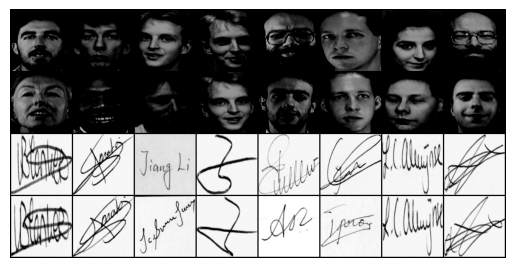

same face: [0. 0. 0. 1. 0. 1. 0. 0.]
same signature: [1 1 0 1 0 0 1 1]
forged signature: [0 0 0 0 0 0 0 0]
entrance allowed: [0 0 0 1 0 0 0 0]


In [5]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[3], example_batch[4]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(f"same face: {example_batch[2].numpy().reshape(-1)}")
print(f"same signature: {example_batch[5].numpy().reshape(-1)}")
print(f"forged signature: {example_batch[6].numpy().reshape(-1)}")
print(f"entrance allowed: {example_batch[7].numpy().reshape(-1)}")


#### Define Train-Test-Split<a class="anchor" id="1c">

[Back to the top](#0) 

## Define Model<a class="anchor" id="2">

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.fc_in_features = self.resnet.fc.in_features
        
        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features
        #output = torch.cat((output1, output2), 1)

        # pass the concatenation to the linear layers
        #output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output1 = self.sigmoid(output1)
        output2 = self.sigmoid(output2)
        
        return output1, output2

In [7]:
from torchsummary import summary
net = SiameseNetwork().cuda()

print(net)

SiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [8]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=5.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      # label = 1 means different people, label = 0 means same people  
      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [12]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=128)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00005 )

Epoch number 0
 Current loss 7.891307353973389

Epoch number 1
 Current loss 7.466920852661133

Epoch number 2
 Current loss 6.908623695373535

Epoch number 3
 Current loss 7.223252296447754

Epoch number 4
 Current loss 6.801324844360352

Epoch number 5
 Current loss 7.637724876403809

Epoch number 6
 Current loss 6.786811828613281

Epoch number 7
 Current loss 7.032955646514893

Epoch number 8
 Current loss 6.823403835296631

Epoch number 9
 Current loss 7.069010257720947

Epoch number 10
 Current loss 7.109229564666748

Epoch number 11
 Current loss 7.239926338195801

Epoch number 12
 Current loss 6.920140266418457

Epoch number 13
 Current loss 6.782481670379639

Epoch number 14
 Current loss 6.696536540985107

Epoch number 15
 Current loss 8.076814651489258

Epoch number 16
 Current loss 6.977807521820068

Epoch number 17
 Current loss 6.885159492492676

Epoch number 18
 Current loss 6.477828025817871

Epoch number 19
 Current loss 7.839208126068115

Epoch number 20
 Current loss 

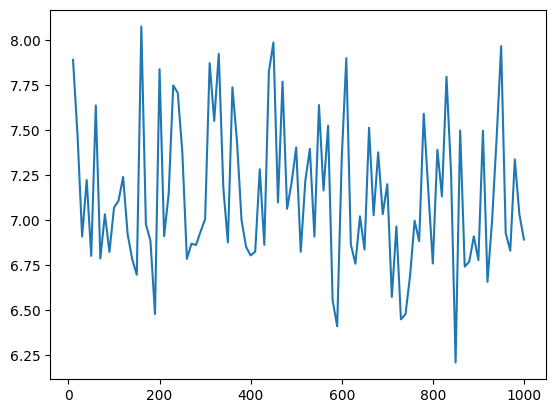

In [14]:

counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (face1, face2, same_face_class, signature1, signature2, same_signature_class, is_signature_forged, is_entrance_allowed) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA

        face1, face2, same_face_class = face1.cuda(), face2.cuda(), same_face_class.cuda()        

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        (output1, output2) = net(face1, face2)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, same_face_class)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

In [11]:
print(torchvision.models.resnet18())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  